# Measurements - Dask Delayed
Here we will go through one of the ways we can measure properties using dask. In this example we are goint to measure regionproperties for each time slice and are concatenating all properties into one large dataframe afterwards. Since this means we won't be converting image arrays into image arrays we need to use different dask functionality than the one implemented in dask.array. An easy way of achieving this is with dask delayed which we will show here. First let's load our data:

In [1]:
import dask.array as da
from napari_pyclesperanto_assistant._advanced_statistics import advanced_statistics
import pyclesperanto_prototype as cle
from dask.distributed import Client
from dask import delayed

# Make sure to select the file location on your machine!
zarr_file = r"C:\Users\ryans\Documents\output data (big)\dask tutorial\lund_zenodo.zarr"
rescaled_stack = da.from_zarr(url=zarr_file, component="rescaled_data")
label_stack = da.from_zarr(url=zarr_file, component="labelled_data")

Now we need a function that measure the region properties and adds a column for the timepoint so we can later identify which cell belongs to which timepoint:

In [2]:
def statistics_with_frame(intensity_image, label_image, timepoint = None):
    import numpy as np
    from napari_pyclesperanto_assistant._advanced_statistics import advanced_statistics
    props = advanced_statistics(
        intensity_image,
        label_image,
        n_neighbors = "2,6,12",
    )
    if not(timepoint is None):
        timepoint_column =np.full(len(props), timepoint)
        props["frame"] = timepoint_column
        
    return props

statistics_with_frame(rescaled_stack[0],label_stack[0],0)

Measurements Completed.


,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio,avg_distance_of_2_nearest_neigbors,avg_distance_of_6_nearest_neigbors,avg_distance_of_12_nearest_neigbors,touching_neighbor_count,frame
0,1,1,21.0,608.0,0.0,45.0,632.0,20.0,25.0,25.0,...,19.861078,18.922398,18.976395,2.281091,2.287437,14.303953,20.167883,28.028103,4.0,0
1,2,2,22.0,582.0,0.0,45.0,603.0,24.0,24.0,22.0,...,32.529827,17.491060,17.328157,1.922234,1.904017,16.902607,19.972225,25.028526,7.0,0
2,3,3,22.0,628.0,0.0,45.0,653.0,14.0,24.0,26.0,...,31.092434,17.111938,17.131552,2.073210,2.075363,14.566701,19.928028,26.635654,4.0,0
3,4,4,24.0,638.0,30.0,40.0,662.0,46.0,17.0,25.0,...,29.705423,14.972995,15.061624,2.412705,2.427176,11.252849,17.009428,23.779453,6.0,0
4,5,5,21.0,601.0,0.0,47.0,624.0,21.0,27.0,24.0,...,36.096573,18.238401,18.073776,1.910139,1.892496,14.780855,20.288206,25.604826,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,2365,2365,480.0,431.0,0.0,497.0,449.0,22.0,18.0,19.0,...,23.799383,16.348860,16.242424,2.089143,2.074825,15.238686,21.866491,27.232681,5.0,0
2365,2366,2366,483.0,448.0,0.0,497.0,467.0,17.0,15.0,20.0,...,21.233978,12.346820,12.292957,1.821168,1.813150,16.268391,18.330360,26.131241,6.0,0
2366,2367,2367,483.0,460.0,10.0,496.0,482.0,26.0,14.0,23.0,...,19.314573,12.012151,11.986337,1.960748,1.956503,10.358383,14.852751,21.333660,6.0,0
2367,2368,2368,485.0,465.0,2.0,496.0,483.0,18.0,12.0,19.0,...,22.116394,13.718150,13.705195,2.360202,2.357704,8.137857,15.356218,23.146223,5.0,0


This function works! Now we can start using dask delayed to have a list of region properties. Since dask delayed does not calculate anything yet what we end up with is an array full of actions to be performed when they are needed:

In [3]:
from dask import delayed

regprops_list = []

for i,(image,label) in enumerate(zip(rescaled_stack,label_stack)):
    regprop = delayed(statistics_with_frame)(image,label,i)
    regprops_list.append(regprop)
    
regprops_list[:10]

[Delayed('statistics_with_frame-7209d2c4-ec89-47cd-8efa-bbb7b573f4ff'),
 Delayed('statistics_with_frame-3a0d2b42-77d5-49e7-8040-8df4d8809caa'),
 Delayed('statistics_with_frame-78209064-c95a-4f3c-9fb6-451d2885705a'),
 Delayed('statistics_with_frame-acfdaf4a-81fe-450b-b93f-c558f97b34bc'),
 Delayed('statistics_with_frame-9c1b5a9a-a6d6-4bd1-87c4-6104740f3f36'),
 Delayed('statistics_with_frame-255379bc-fed9-43c7-9252-36b6f893bd42'),
 Delayed('statistics_with_frame-12a61281-2e98-44d8-bc34-bcc2bc220a02'),
 Delayed('statistics_with_frame-3e4ac1a0-2f92-4790-8ce0-c9e8471010ed'),
 Delayed('statistics_with_frame-406111a0-f74f-47d9-b4db-4aa673227ae8'),
 Delayed('statistics_with_frame-0493c8f2-31b9-4e3c-ba32-ab2f3af8939e')]

We can now concatenate the dataframes (also delaying this function) to retrieve our final dataframe:

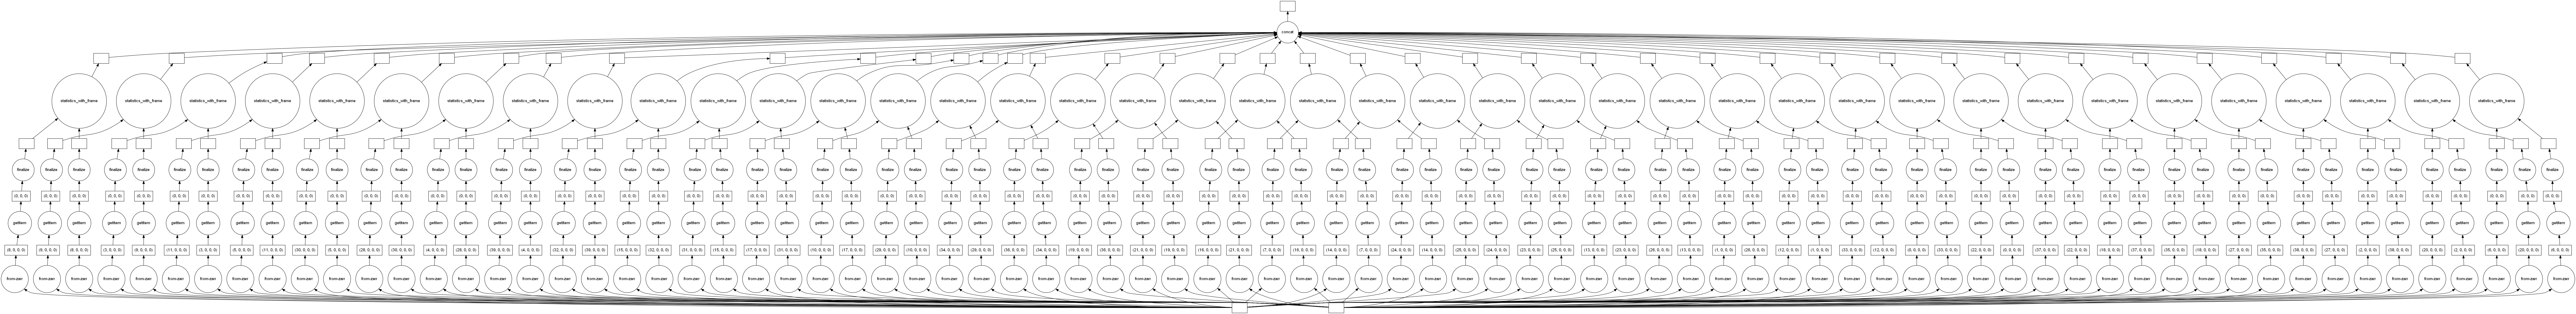

In [4]:
import pandas as pd
concatenated_dataframe = delayed(pd.concat)(regprops_list,axis = 0)
concatenated_dataframe.visualize()

As you can see dask has created a graph showing how this computation will be performed. Once we are happy with it we can set up a client and run the computation, taking advantage of dasks ability to parrallelise the computation:

In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2,threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 23.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49572,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 23.71 GiB
Comm: tcp://127.0.0.1:49592,Total threads: 1
Dashboard: http://127.0.0.1:49593/status,Memory: 11.86 GiB
Nanny: tcp://127.0.0.1:49575,


In [6]:
result = concatenated_dataframe.compute()

As usual we need to shutdown the client in order to avoid the same port being used multiple times. Afterwards we can take a look at our result:

In [7]:
client.shutdown()

In [8]:
result

,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio,avg_distance_of_2_nearest_neigbors,avg_distance_of_6_nearest_neigbors,avg_distance_of_12_nearest_neigbors,touching_neighbor_count,frame
0,1,1,21.0,608.0,0.0,45.0,632.0,20.0,25.0,25.0,...,19.861078,18.922398,18.976395,2.281091,2.287437,14.303953,20.167883,28.028103,4.0,0
1,2,2,22.0,582.0,0.0,45.0,603.0,24.0,24.0,22.0,...,32.529827,17.491060,17.328157,1.922234,1.904017,16.902607,19.972225,25.028526,7.0,0
2,3,3,22.0,628.0,0.0,45.0,653.0,14.0,24.0,26.0,...,31.092434,17.111938,17.131552,2.073210,2.075363,14.566701,19.928028,26.635654,4.0,0
3,4,4,24.0,638.0,30.0,40.0,662.0,46.0,17.0,25.0,...,29.705423,14.972995,15.061624,2.412705,2.427176,11.252849,17.009428,23.779453,6.0,0
4,5,5,21.0,601.0,0.0,47.0,624.0,21.0,27.0,24.0,...,36.096573,18.238401,18.073776,1.910139,1.892496,14.780855,20.288206,25.604826,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,2206,2206,486.0,518.0,17.0,496.0,531.0,37.0,11.0,14.0,...,43.334099,10.630865,10.631902,1.811498,1.811672,28.740442,39.720795,53.289196,0.0,39
2206,2207,2207,489.0,391.0,23.0,498.0,402.0,40.0,10.0,12.0,...,35.444271,9.312797,9.321238,1.811814,1.813471,28.416721,38.330193,53.338940,0.0,39
2207,2208,2208,491.0,447.0,15.0,501.0,460.0,36.0,11.0,14.0,...,52.075928,10.681500,10.680285,1.795046,1.794833,36.140854,43.075577,57.240200,0.0,39
2208,2209,2209,495.0,486.0,9.0,497.0,489.0,14.0,3.0,4.0,...,15.178794,2.769472,2.757771,1.620038,1.613064,34.790348,49.083954,62.619461,0.0,39


It looks like we don't have any missing values in the table meaning the computation most likely worked without any errors. All that's left to do is save it:

In [9]:
result.to_csv("region_properties_concatenated.csv")